# Automatic Detection of Hot-Rolled Steel Strips Surface Defects using Convolutional Neural Network
#### This project aims to automatically detect surface defects in Hot-Rolled Steel Strips such as rolled-in scale, patches, crazing, pitted surface, inclusion and scratches (as depicted in the image below). A Convolutional Neural Network Model is developed and trained on the NEU Metal Surface Defects Database which contains 1800 grayscale images with 300 samples of each of the six different kinds of surface defects.

## 1. Importing Relevant Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import load_files
# from tensorflow.keras.utils import np_utils
import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img

## 2. Importing the NEU Metal Surface Defect Dataset

In [2]:
# 定义路径
train_dir = '../NEU Metal Surface Defects Data/train'
val_dir = '../NEU Metal Surface Defects Data/valid'
test_dir = '../NEU Metal Surface Defects Data/test'

# 检查并打印路径下的目录和文件
def list_directory_contents(path, description):
    try:
        contents = os.listdir(path)
        print(f"{description}: {contents}")
    except FileNotFoundError:
        print(f"Error: {path} not found.")
    except NotADirectoryError:
        print(f"Error: {path} is not a directory.")
    except PermissionError:
        print(f"Error: Permission denied for {path}.")

base_dir = '../NEU Metal Surface Defects Data'
list_directory_contents(base_dir, "Path")
list_directory_contents(train_dir, "Train")
list_directory_contents(test_dir, "Test")
list_directory_contents(val_dir, "Validation")

Path: ['valid', 'test', 'train']
Train: ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']
Test: ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']
Validation: ['Inclusion', 'Patches', 'Rolled', 'Pitted', 'Scratches', 'Crazing']


#### For each Class, the Training Data includes 276 Images, Validation & Test sets have 12 images each.

In [3]:
print("Inclusion Defect")
print("Training Images:",len(os.listdir(train_dir+'/'+'Inclusion')))
print("Testing Images:",len(os.listdir(test_dir+'/'+'Inclusion')))
print("Validation Images:",len(os.listdir(val_dir+'/'+'Inclusion')))

Inclusion Defect
Training Images: 276
Testing Images: 12
Validation Images: 12


## 3. Data Pre-processing

In [4]:
# Rescaling all Images by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training images are put in batches of 10
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Validation images are put in batches of 10
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


#### Setting upper Limit of Max 98% training accuracy

In [5]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

## 4. Defining the CNN Architecture

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

/opt/anaconda3/envs/dl/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',"recall"])

In [8]:
# tf.keras.utils.plot_model(
#     model,
#     to_file='cnn_architecture.png',
#     show_shapes=True)

## 5. Training the Defined CNN Model

In [9]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20


/opt/anaconda3/envs/dl/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.2766 - loss: 1.7911 - recall: 0.0235 - val_accuracy: 0.5556 - val_loss: 1.1384 - val_recall: 0.1806
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5181 - loss: 1.2702 - recall: 0.2422 - val_accuracy: 0.7639 - val_loss: 0.6773 - val_recall: 0.5417
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.6392 - loss: 0.9311 - recall: 0.5294 - val_accuracy: 0.4861 - val_loss: 1.1382 - val_recall: 0.4583
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.6954 - loss: 0.8864 - recall: 0.6108 - val_accuracy: 0.6528 - val_loss: 0.9395 - val_recall: 0.6250
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.7982 - loss: 0.6625 - recall: 0.7436 - val_accuracy: 0.9444 - val_loss: 0.2047 - val_recall: 0.9167
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.8265 - loss: 0.5803 - recall: 0.7822 - val_accuracy: 0.8611 - val_loss: 0.5421 - val_recall: 0.8472
Epo

## 6. Analysing the Accuracy & the Loss Curves

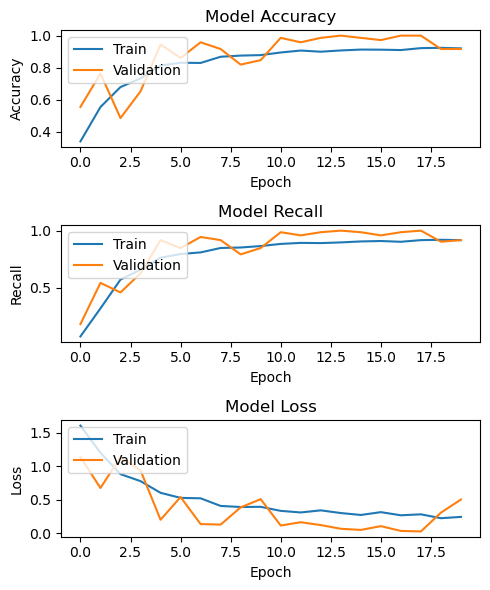

In [14]:


# 设置图像的长和宽为 5 和 10
plt.figure(figsize=(5, 6))

# 绘制准确率
plt.subplot(311)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# 绘制召回率
plt.subplot(312)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# 绘制损失
plt.subplot(313)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## 7. Test Result visualization

In [100]:
# Loading file names & their respective target labels into numpy array
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
x_test, y_test,target_labels = load_dataset(test_dir)
no_of_classes = len(np.unique(y_test))
no_of_classes

NameError: name 'load_files' is not defined

In [101]:
# y_test = np_utils.to_categorical(y_test,no_of_classes)
from keras.utils import to_categorical
# print(y_test)
y_test = to_categorical(y_test, num_classes=no_of_classes)

# print(y_test.shape)
# print(y_test)

AttributeError: `np.complex_` was removed in the NumPy 2.0 release. Use `np.complex128` instead.

In [102]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

NameError: name 'x_test' is not defined

In [103]:
x_test = x_test.astype('float32')/255
x_test

NameError: name 'x_test' is not defined

## Results of Hot-Rolled Steel Strips Surface Defect Detection

In [104]:
# Plotting Random Sample of test images, their predicted labels, and ground truth
y_pred = model.predict(x_test)
print(y_pred)
fig = plt.figure(figsize=(10, 10))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

NameError: name 'model' is not defined